# Web Scraping con BeautifulSoup de canciones más escuchadas de Spotify

In [36]:
import os
from bs4 import BeautifulSoup
import requests
import time
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [37]:
# Paso 1: Descargar el HTML de la página web
url = "https://en.wikipedia.org/wiki/List_of_most-streamed_songs_on_Spotify"
response = requests.get(url)

if response.status_code == 200:
    html_content = response.text  # Guardamos el HTML completo como texto

    # Paso 2: Analizar el HTML con BeautifulSoup (aunque usaremos read_html más adelante)
    soup = BeautifulSoup(html_content, "html.parser")

    # Paso 3: Usar pandas.read_html() para extraer las tablas automáticamente
    tables = pd.read_html(html_content)

    # Mostramos cuántas tablas hay (por si hay más de una)
    print(f"Se encontraron {len(tables)} tablas.")

    # Por inspección sabemos que la primera tabla suele ser la correcta
    df = tables[0]

    # Mostramos una vista previa
    print(df.head())

    # Paso 4: Limpiar el DataFrame
    df.columns = [col.strip().lower().replace(" ", "_") for col in df.columns]

    # Limpiar la columna como texto
    df['streams_(billions)'] = df['streams_(billions)'].astype(str)
    df['streams_(billions)'] = df['streams_(billions)'].str.replace("B", "", regex=False)
    df['streams_(billions)'] = df['streams_(billions)'].str.replace("$", "", regex=False)
    df['streams_(billions)'] = df['streams_(billions)'].str.replace(",", "", regex=False)

    # Filtrar solo las filas que son numéricas
    df = df[df['streams_(billions)'].str.match(r'^\d+\.?\d*$')]

    # Ahora sí convertir a float
    df['streams_(billions)'] = df['streams_(billions)'].astype(float)

    # Eliminar filas vacías o con valores nulos
    df.dropna(inplace=True)

    # Reiniciar índices después de limpieza
    df.reset_index(drop=True, inplace=True)

    # Mostrar resultado limpio
    print("\nDataFrame limpio:")
    print(df.head())

else:
    print(f"Error al acceder a la página: {response.status_code}")


Se encontraron 27 tablas.
  Rank                 Song                 Artist(s) Streams (billions)  \
0    1    "Blinding Lights"                The Weeknd              4.782   
1    2       "Shape of You"                Ed Sheeran              4.300   
2    3  "Someone You Loved"             Lewis Capaldi              3.858   
3    4            "Starboy"  The Weeknd and Daft Punk              3.828   
4    5          "As It Was"              Harry Styles              3.824   

        Release date Ref.  
0   29 November 2019  [2]  
1     6 January 2017  [3]  
2    8 November 2018  [4]  
3  21 September 2016  [5]  
4       1 April 2022  [6]  

DataFrame limpio:
  rank                 song                 artist(s)  streams_(billions)  \
0    1    "Blinding Lights"                The Weeknd               4.782   
1    2       "Shape of You"                Ed Sheeran               4.300   
2    3  "Someone You Loved"             Lewis Capaldi               3.858   
3    4            "Sta

C:\Users\mafer\AppData\Local\Temp\ipykernel_25108\1982780571.py:12: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(html_content)
C:\Users\mafer\AppData\Local\Temp\ipykernel_25108\1982780571.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['streams_(billions)'] = df['streams_(billions)'].astype(float)
C:\Users\mafer\AppData\Local\Temp\ipykernel_25108\1982780571.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

In [38]:
df.to_csv("spotify_top_streamed_songs.csv", index=False)


In [39]:
print(df.columns)


Index(['rank', 'song', 'artist(s)', 'streams_(billions)', 'release_date',
       'ref.'],
      dtype='object')


In [40]:
# Paso 5: Conectar a una base de datos SQLite (la crea si no existe)
conn = sqlite3.connect("spotify.db")
cursor = conn.cursor()

# Eliminar la tabla si ya existe para evitar errores al repetir el código
cursor.execute("DROP TABLE IF EXISTS songs")

# Crear la tabla con columnas similares al DataFrame
cursor.execute("""
    CREATE TABLE songs (
        rank INTEGER,
        song TEXT,
        artist TEXT,
        streams REAL,
        released TEXT
    )
""")

# Insertar los valores del DataFrame en la tabla
for _, row in df.iterrows():
    cursor.execute("""
        INSERT INTO songs (rank, song, artist, streams, released)
        VALUES (?, ?, ?, ?, ?)
    """, (
        int(row['rank']),
        str(row['song']),
        str(row['artist(s)']),
        float(row['streams_(billions)']),
        str(row['release_date'])
    ))

# Confirmar (commit) los cambios y cerrar conexión
conn.commit()
conn.close()

print("✅ Datos almacenados correctamente en la base de datos 'spotify.db'")


✅ Datos almacenados correctamente en la base de datos 'spotify.db'


C:\Users\mafer\AppData\Local\Temp\ipykernel_25108\2669705720.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
C:\Users\mafer\AppData\Local\Temp\ipykernel_25108\2669705720.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='streams_(billions)', y='song', data=top_10_songs, palette='viridis')


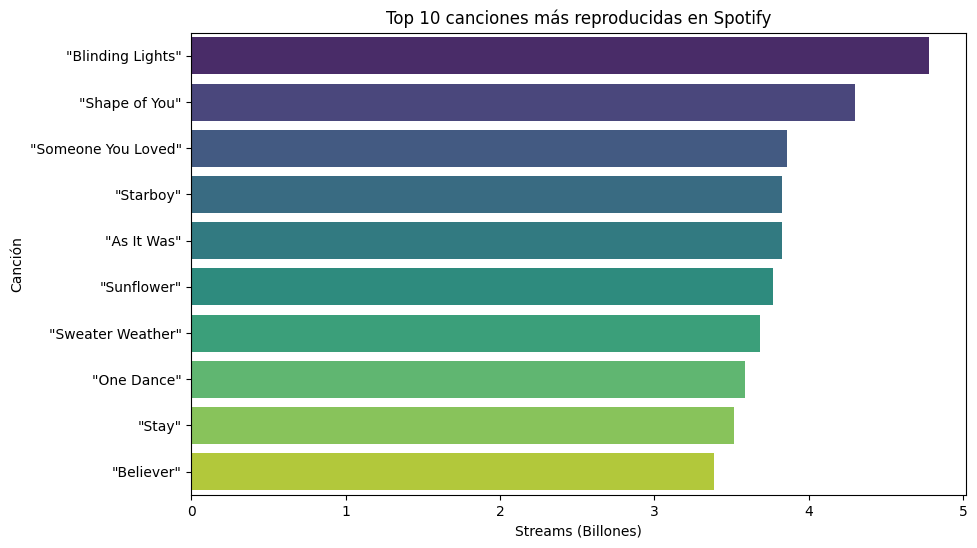

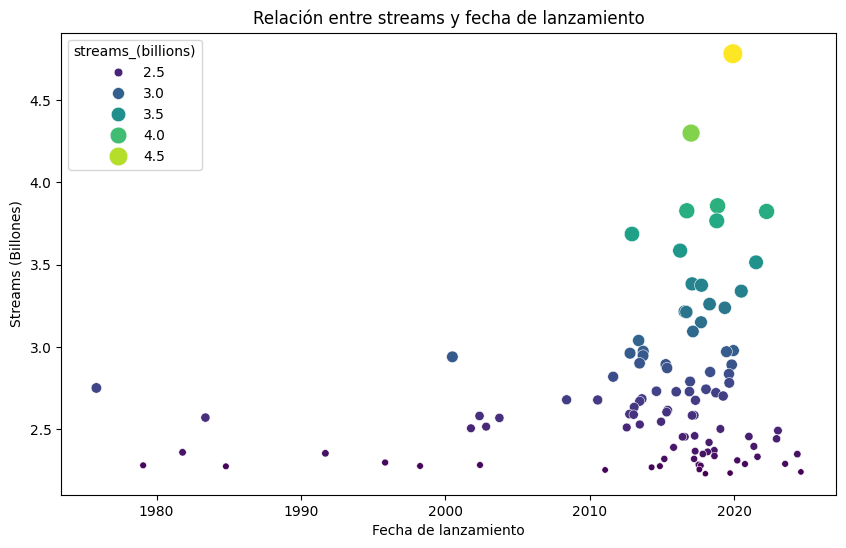

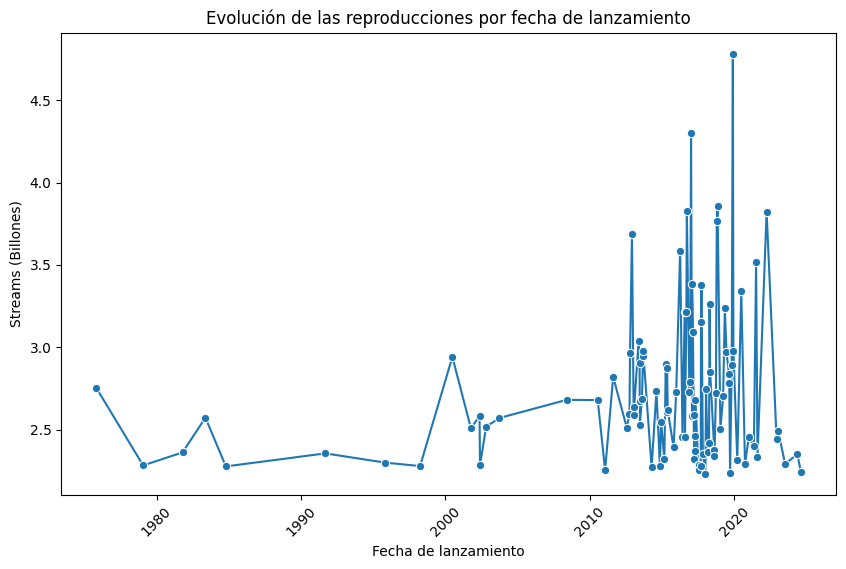

In [41]:
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

# 1. Gráfico de barras: Top 10 canciones por cantidad de streams
top_10_songs = df[['song', 'streams_(billions)']].nlargest(10, 'streams_(billions)')

plt.figure(figsize=(10, 6))
sns.barplot(x='streams_(billions)', y='song', data=top_10_songs, palette='viridis')
plt.title("Top 10 canciones más reproducidas en Spotify")
plt.xlabel("Streams (Billones)")
plt.ylabel("Canción")
plt.show()

# 2. Gráfico de dispersión: Relación entre streams y fecha de lanzamiento
plt.figure(figsize=(10, 6))
sns.scatterplot(x='release_date', y='streams_(billions)', data=df, hue='streams_(billions)', palette='viridis', size='streams_(billions)', sizes=(20, 200))
plt.title("Relación entre streams y fecha de lanzamiento")
plt.xlabel("Fecha de lanzamiento")
plt.ylabel("Streams (Billones)")
plt.show()

# 3. Gráfico de líneas: Evolución de las reproducciones por fecha de lanzamiento
df_sorted = df.sort_values(by='release_date')

plt.figure(figsize=(10, 6))
sns.lineplot(x='release_date', y='streams_(billions)', data=df_sorted, marker='o')
plt.title("Evolución de las reproducciones por fecha de lanzamiento")
plt.xlabel("Fecha de lanzamiento")
plt.ylabel("Streams (Billones)")
plt.xticks(rotation=45)
plt.show()
